In [1]:
!nvidia-smis

zsh:1: command not found: nvidia-smis


In [1]:
import numpy as np
import pandas as pd
import os
import random
import torch
from configs.configs import Configs
from models.predictor_model import EssayScorer
from transformers import AutoConfig
from utils.create_embedding_feautres import create_embedding_features
from utils.dvrl_utils import remove_top_p_sample, fit_func, pred_func, calc_qwk, random_remove_sample, get_dev_sample
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
from sklearn.model_selection import train_test_split
import pickle

/Users/takumishibata/.pyenv/versions/3.11.5/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
test_prompt_id = 5
# output_path = f'outputs/DVRL_DomainAdaptation/'
# output_path = f'outputs/DVRL_DomainAdaptation{test_prompt_id}/'
# output_path = f'outputs/DVRL_DomainAdaptation{test_prompt_id}_devsize0.01/'
output_path = f'outputs/DVRL_DomainAdaptation{test_prompt_id}_devsize30/'

seed = 12
np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
configs = Configs()
attribute_name = 'score'

# Load data
data_path = configs.DATA_PATH3 + str(test_prompt_id) + '/'
model_name = 'microsoft/deberta-v3-large'

cpu


load data from data/cross_prompt_attributes/5/...
Loading embedding from cache...
Selected 30 samples.
Selected sample indices: [1414, 1671, 1676, 838, 1434, 329, 272, 1140, 335, 1269, 1149, 1693, 1064, 195, 1591, 1511, 169, 741, 296, 1749, 716, 1576, 1770, 615, 294, 648, 1530, 1296, 1449, 621]
X_train:  (9524, 1024)
Y_train:  (9524,)
Y_train max:  1.0
Y_train min:  0.0
X_test:  (1775, 1024)
Y_test:  (1775,)
Y_test max:  1.0
Y_test min:  0.0
Creating predictor model...
QWK: 0.6985
Creating predictor model...
QWK: 0.7105
Creating predictor model...
QWK: 0.5506
Creating predictor model...
QWK: 0.6732
Creating predictor model...
QWK: 0.6368
Creating predictor model...
QWK: 0.5326
Creating predictor model...
QWK: 0.6408
Creating predictor model...
QWK: 0.5920
Creating predictor model...
QWK: 0.5651
Creating predictor model...
QWK: 0.3447
Creating predictor model...
QWK: 0.3356
Creating predictor model...
QWK: 0.2973
Creating predictor model...
QWK: 0.2149
Creating predictor model...
QWK: 0

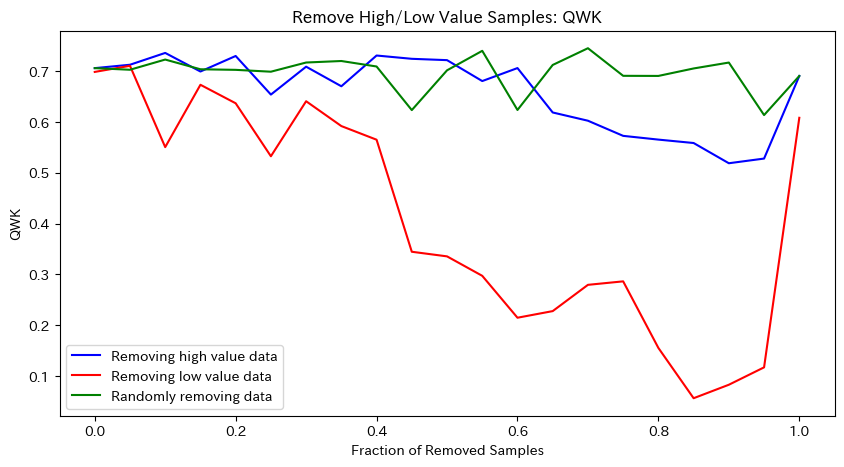

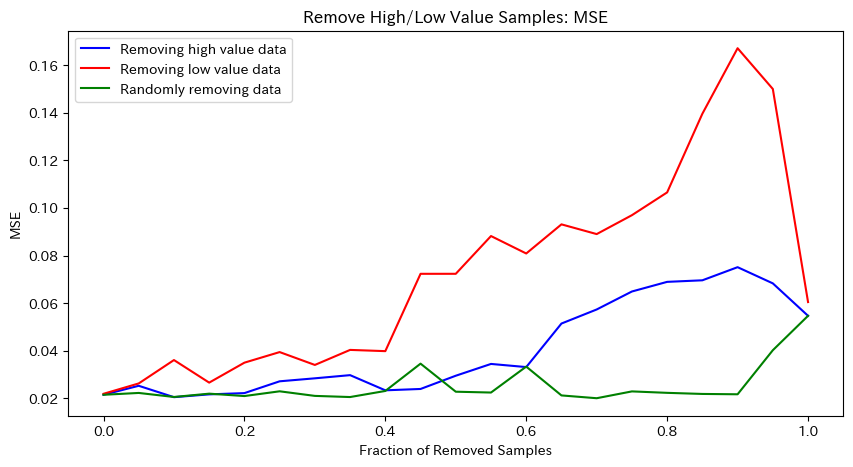

In [4]:
train_data, _, test_data = create_embedding_features(data_path, test_prompt_id, attribute_name, model_name, device)
train_features, test_features = train_data['essay'], test_data['essay']
y_train, y_test, id_test = train_data['normalized_label'], test_data['normalized_label'], test_data['essay_id']
dev_features, test_features, y_dev, y_test, dev_ids, _ = get_dev_sample(test_features, y_test, dev_size=30)

# use dev data for training
train_features = np.concatenate([train_features, dev_features], axis=0)
y_train = np.concatenate([y_train, y_dev], axis=0)

# print info
print('================================')
print('X_train: ', train_features.shape)
print('Y_train: ', y_train.shape)
print('Y_train max: ', np.max(y_train))
print('Y_train min: ', np.min(y_train))


print('================================')
print('X_test: ', test_features.shape)
print('Y_test: ', y_test.shape)
print('Y_test max: ', np.max(y_test))
print('Y_test min: ', np.min(y_test))
print('================================')

# Remove high and low value samples
low_qwks = []
low_mse = []
for p in np.arange(0.0, 1.01, 0.05):
    # Create predictor
    print('Creating predictor model...')
    config = AutoConfig.from_pretrained(model_name)
    pred_model = EssayScorer(config.hidden_size)

    weights = remove_top_p_sample(np.load(output_path + 'estimated_data_value.npy'), top_p=p, ascending=True)
    weights = np.concatenate([weights, np.ones(dev_features.shape[0])], axis=0)
    history = fit_func(pred_model, train_features, y_train, batch_size=256, epochs=100, device=device, sample_weight=weights)

    y_pred = pred_func(pred_model, test_features, batch_size=256, device=device)
    qwk = calc_qwk(y_test, y_pred, test_prompt_id, 'score')
    mse = mean_squared_error(y_test, y_pred)
    print(f'QWK: {qwk:.4f}')
    low_qwks.append(qwk)
    low_mse.append(mse)

np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

high_qwks = []
high_mse = []
for p in np.arange(0.0, 1.01, 0.05):
    # Create predictor
    print('Creating predictor model...')
    config = AutoConfig.from_pretrained(model_name)
    pred_model = EssayScorer(config.hidden_size)

    weights = remove_top_p_sample(np.load(output_path + 'estimated_data_value.npy'), top_p=p, ascending=False)
    weights = np.concatenate([weights, np.ones(dev_features.shape[0])], axis=0)
    history = fit_func(pred_model, train_features, y_train, batch_size=256, epochs=100, device=device, sample_weight=weights)

    y_pred = pred_func(pred_model, test_features, batch_size=256, device=device)
    qwk = calc_qwk(y_test, y_pred, test_prompt_id, 'score')
    mse = mean_squared_error(y_test, y_pred)
    print(f'QWK: {qwk:.4f}')
    high_qwks.append(qwk)
    high_mse.append(mse)


np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

random_qwks = []
random_mse = []
for p in np.arange(0.0, 1.01, 0.05):
    # Create predictor
    print('Creating predictor model...')
    config = AutoConfig.from_pretrained(model_name)
    pred_model = EssayScorer(config.hidden_size)

    weights = random_remove_sample(np.load(output_path + 'estimated_data_value.npy'), remove_p=p)
    weights = np.concatenate([weights, np.ones(dev_features.shape[0])], axis=0)
    history = fit_func(pred_model, train_features, y_train, batch_size=256, epochs=100, device=device, sample_weight=weights)

    y_pred = pred_func(pred_model, test_features, batch_size=256, device=device)
    qwk = calc_qwk(y_test, y_pred, test_prompt_id, 'score')
    mse = mean_squared_error(y_test, y_pred)
    print(f'QWK: {qwk:.4f}')
    random_qwks.append(qwk)
    random_mse.append(mse)

# plot
p = np.arange(0.0, 1.01, 0.05)
plt.figure(figsize=(10, 5))
plt.plot(p, high_qwks, label='Removing high value data', color='blue')
plt.plot(p, low_qwks, label='Removing low value data', color='red')
plt.plot(p, random_qwks, label='Randomly removing data', color='green')
plt.title('Remove High/Low Value Samples: QWK')
plt.xlabel('Fraction of Removed Samples')
plt.ylabel('QWK')
plt.legend()
plt.savefig(output_path + 'remove_high_low_samples_qwk.png')

plt.figure(figsize=(10, 5))
plt.plot(p, high_mse, label='Removing high value data', color='blue')
plt.plot(p, low_mse, label='Removing low value data', color='red')
plt.plot(p, random_mse, label='Randomly removing data', color='green')
plt.title('Remove High/Low Value Samples: MSE')
plt.xlabel('Fraction of Removed Samples')
plt.ylabel('MSE')
plt.legend()
plt.savefig(output_path + 'remove_high_low_samples_mse.png')

output_qwk = np.array([np.arange(0.0, 1.01, 0.05).tolist(), high_qwks, low_qwks, random_qwks])
output_mse = np.array([np.arange(0.0, 1.01, 0.05).tolist(), high_mse, low_mse, random_mse])
pd.DataFrame(output_qwk).to_csv(output_path + 'mlp_qwk.csv', index=False, header=False)
pd.DataFrame(output_mse).to_csv(output_path + 'mlp_mse.csv', index=False, header=False)

In [4]:
data_values = np.load(output_path + 'estimated_data_value.npy')

In [5]:
data_values.mean()

0.81940633

In [6]:
data_values.max()

0.8235809

In [7]:
data_values.min()

0.8171776

<Axes: ylabel='Count'>

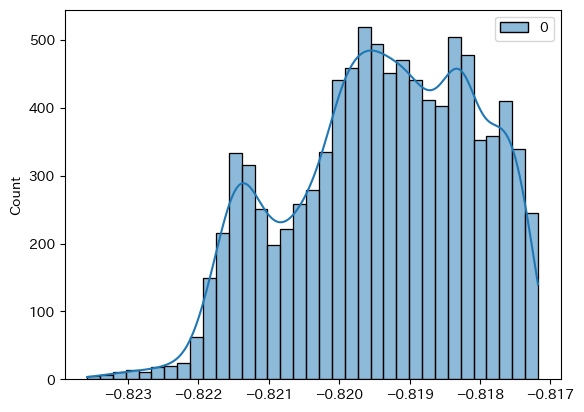

In [8]:
sns.histplot(-data_values, kde=True)

### 訓練に使用したテストデータのみを用いて学習する

In [4]:
from utils.create_embedding_feautres import load_data, normalize_scores, create_data_loader
from transformers import AutoTokenizer, AutoModel, AutoConfig

In [13]:
data = load_data(data_path)

features = np.array(data['test']['feature'])
labels = np.array(data['test']['label'])
prompts = np.array(data['test']['essay_set'])
ids = np.array(data['test']['essay_id'])
# Normalize scores
normalized_labels = normalize_scores(labels, prompts, attribute_name)


sample_id = np.load(output_path + 'dev_ids.npy')
not_sample_id = np.array([i for i in range(len(features)) if i not in sample_id])
print(sample_id)

[1691  446  689  653  945 1548 1244  452 1413  916 1447  871 1645  476
 1368  878  746]


In [14]:
train_data = {}
test_data = {}

train_data['feature'] = features[sample_id]
train_data['normalized_label'] = normalized_labels[sample_id]
train_data['essay_set'] = prompts[sample_id]

test_data['feature'] = features[not_sample_id]
test_data['normalized_label'] = normalized_labels[not_sample_id]
test_data['essay_set'] = prompts[not_sample_id]

print(train_data['feature'].shape)
print(test_data['feature'].shape)

(17,)
(1766,)


In [16]:
import torch
import torch.nn as nn
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from utils.evaluation import train_epoch, evaluate_epoch


model_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)
config = AutoConfig.from_pretrained(model_name)

train_loader = create_data_loader(train_data, tokenizer, max_length=512, batch_size=32)
test_loader = create_data_loader(test_data, tokenizer, max_length=512, batch_size=32)

# set parameters
EPOCHS = 30

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device('mps')
print(f"Using {device}")

# Define the model
class PreTrainedScorer(nn.Module):
    def __init__(self, base_model: AutoModel, hidden_size=768, num_labels=1):
        super(PreTrainedScorer, self).__init__()
        self.base_model = base_model
        self.regressor = nn.Linear(hidden_size, num_labels)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        logits = self.regressor(pooled_output)
        return self.sigmoid(logits)

# Initialize the model
model = PreTrainedScorer(model, hidden_size=config.hidden_size).to(device)

# Define loss function, optimizer, and scheduler
loss_fn = nn.MSELoss(reduction='none').to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_loader)*EPOCHS)

# Training loop
for epoch in range(EPOCHS):
    print('valuationに使用したデータだけで訓練中')
    print(f"Epoch {epoch+1}/{EPOCHS}")

    # Training Set
    train_loss = train_epoch(model, train_loader, loss_fn, optimizer, device, scheduler, use_weight=False)
    print(f"Training loss: {train_loss}")

    # Test Set
    eval_history = evaluate_epoch(model, test_loader, loss_fn, device, attribute_name)
    print(f"Test loss: {eval_history['loss']:.4f}")

    print(f'[TEST] -> QWK: {eval_history["qwk"]: .3f}, CORR: {eval_history["corr"]: .3f}, RMSE: {eval_history["rmse"]: .3f}')

best_val_metrics = [eval_history[met] for met in ['qwk', 'lwk', 'corr', 'rmse', 'mae']]

pd.DataFrame(np.array(best_val_metrics).reshape(1, 5), columns=['qwk', 'lwk', 'corr', 'rmse', 'mae']).to_csv(output_path + f'baseline_metrics{test_prompt_id}.csv', index=False, header=True)

Using cuda
Epoch 1/30


Training: 100%|████████████████████████████████████████| 1/1 [00:00<00:00,  1.83batch/s, loss=0.155]


Training loss: 0.1548919379711151


Evaluation: 100%|█████████████████████████████████████| 56/56 [00:07<00:00,  7.45batch/s, loss=0.04]


[-0.00381972]
Test loss: 0.0400
[TEST] -> QWK: -0.004, CORR:  0.089, RMSE:  0.201
Epoch 2/30


Training: 100%|████████████████████████████████████████| 1/1 [00:00<00:00,  4.72batch/s, loss=0.135]


Training loss: 0.1352842003107071


Evaluation: 100%|███████████████████████████████████| 56/56 [00:07<00:00,  7.45batch/s, loss=0.0388]


[0.0356079]
Test loss: 0.0388
[TEST] -> QWK:  0.036, CORR:  0.348, RMSE:  0.198
Epoch 3/30


Training: 100%|████████████████████████████████████████| 1/1 [00:00<00:00,  4.60batch/s, loss=0.118]


Training loss: 0.11810848116874695


Evaluation: 100%|███████████████████████████████████| 56/56 [00:07<00:00,  7.43batch/s, loss=0.0293]


[0.18461571]
Test loss: 0.0293
[TEST] -> QWK:  0.185, CORR:  0.474, RMSE:  0.172
Epoch 4/30


Training: 100%|████████████████████████████████████████| 1/1 [00:00<00:00,  4.78batch/s, loss=0.101]


Training loss: 0.10073859244585037


Evaluation: 100%|███████████████████████████████████| 56/56 [00:07<00:00,  7.44batch/s, loss=0.0204]


[0.18965811]
Test loss: 0.0204
[TEST] -> QWK:  0.190, CORR:  0.513, RMSE:  0.144
Epoch 5/30


Training: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  4.64batch/s, loss=0.0928]


Training loss: 0.09278526157140732


Evaluation: 100%|███████████████████████████████████| 56/56 [00:07<00:00,  7.42batch/s, loss=0.0169]


[0.32758016]
Test loss: 0.0169
[TEST] -> QWK:  0.328, CORR:  0.539, RMSE:  0.131
Epoch 6/30


Training: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  4.50batch/s, loss=0.0782]


Training loss: 0.07821322977542877


Evaluation: 100%|███████████████████████████████████| 56/56 [00:07<00:00,  7.41batch/s, loss=0.0162]


[0.37643665]
Test loss: 0.0162
[TEST] -> QWK:  0.376, CORR:  0.538, RMSE:  0.128
Epoch 7/30


Training: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  4.51batch/s, loss=0.0699]


Training loss: 0.06987261772155762


Evaluation: 100%|███████████████████████████████████| 56/56 [00:07<00:00,  7.40batch/s, loss=0.0158]


[0.39065881]
Test loss: 0.0158
[TEST] -> QWK:  0.391, CORR:  0.542, RMSE:  0.126
Epoch 8/30


Training: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  4.53batch/s, loss=0.0642]


Training loss: 0.0642240047454834


Evaluation: 100%|███████████████████████████████████| 56/56 [00:07<00:00,  7.52batch/s, loss=0.0153]


[0.41872143]
Test loss: 0.0153
[TEST] -> QWK:  0.419, CORR:  0.553, RMSE:  0.124
Epoch 9/30


Training: 100%|█████████████████████████████████████████| 1/1 [00:00<00:00,  4.64batch/s, loss=0.06]


Training loss: 0.059991758316755295


Evaluation: 100%|███████████████████████████████████| 56/56 [00:07<00:00,  7.55batch/s, loss=0.0149]


[0.45718233]
Test loss: 0.0149
[TEST] -> QWK:  0.457, CORR:  0.564, RMSE:  0.123
Epoch 10/30


Training: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  4.78batch/s, loss=0.0537]


Training loss: 0.05368947982788086


Evaluation: 100%|███████████████████████████████████| 56/56 [00:07<00:00,  7.53batch/s, loss=0.0148]


[0.4823607]
Test loss: 0.0148
[TEST] -> QWK:  0.482, CORR:  0.570, RMSE:  0.122
Epoch 11/30


Training: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  4.63batch/s, loss=0.0494]


Training loss: 0.04942435398697853


Evaluation: 100%|███████████████████████████████████| 56/56 [00:07<00:00,  7.54batch/s, loss=0.0143]


[0.49607256]
Test loss: 0.0143
[TEST] -> QWK:  0.496, CORR:  0.583, RMSE:  0.120
Epoch 12/30


Training: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  4.83batch/s, loss=0.0449]


Training loss: 0.04486304894089699


Evaluation: 100%|███████████████████████████████████| 56/56 [00:07<00:00,  7.54batch/s, loss=0.0141]


[0.50808381]
Test loss: 0.0141
[TEST] -> QWK:  0.508, CORR:  0.591, RMSE:  0.119
Epoch 13/30


Training: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  4.46batch/s, loss=0.0385]


Training loss: 0.038532376289367676


Evaluation: 100%|████████████████████████████████████| 56/56 [00:07<00:00,  7.50batch/s, loss=0.014]


[0.51361584]
Test loss: 0.0140
[TEST] -> QWK:  0.514, CORR:  0.596, RMSE:  0.119
Epoch 14/30


Training: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  4.54batch/s, loss=0.0353]


Training loss: 0.03534845635294914


Evaluation: 100%|████████████████████████████████████| 56/56 [00:07<00:00,  7.53batch/s, loss=0.014]


[0.51738814]
Test loss: 0.0140
[TEST] -> QWK:  0.517, CORR:  0.602, RMSE:  0.118
Epoch 15/30


Training: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  4.71batch/s, loss=0.0359]


Training loss: 0.03590593859553337


Evaluation: 100%|███████████████████████████████████| 56/56 [00:07<00:00,  7.55batch/s, loss=0.0138]


[0.54104841]
Test loss: 0.0138
[TEST] -> QWK:  0.541, CORR:  0.613, RMSE:  0.117
Epoch 16/30


Training: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  4.61batch/s, loss=0.0341]


Training loss: 0.03408798947930336


Evaluation: 100%|███████████████████████████████████| 56/56 [00:07<00:00,  7.53batch/s, loss=0.0137]


[0.53504967]
Test loss: 0.0137
[TEST] -> QWK:  0.535, CORR:  0.616, RMSE:  0.117
Epoch 17/30


Training: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  4.74batch/s, loss=0.0286]


Training loss: 0.028576837852597237


Evaluation: 100%|███████████████████████████████████| 56/56 [00:07<00:00,  7.54batch/s, loss=0.0136]


[0.52849958]
Test loss: 0.0136
[TEST] -> QWK:  0.528, CORR:  0.618, RMSE:  0.117
Epoch 18/30


Training: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  4.54batch/s, loss=0.0306]


Training loss: 0.0306075531989336


Evaluation: 100%|███████████████████████████████████| 56/56 [00:07<00:00,  7.53batch/s, loss=0.0138]


[0.50335609]
Test loss: 0.0138
[TEST] -> QWK:  0.503, CORR:  0.615, RMSE:  0.117
Epoch 19/30


Training: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  4.38batch/s, loss=0.0275]


Training loss: 0.02747328206896782


Evaluation: 100%|███████████████████████████████████| 56/56 [00:07<00:00,  7.55batch/s, loss=0.0141]


[0.48064588]
Test loss: 0.0141
[TEST] -> QWK:  0.481, CORR:  0.612, RMSE:  0.118
Epoch 20/30


Training: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  4.27batch/s, loss=0.0245]


Training loss: 0.024470428004860878


Evaluation: 100%|███████████████████████████████████| 56/56 [00:07<00:00,  7.55batch/s, loss=0.0144]


[0.46976668]
Test loss: 0.0144
[TEST] -> QWK:  0.470, CORR:  0.609, RMSE:  0.120
Epoch 21/30


Training: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  4.29batch/s, loss=0.0254]


Training loss: 0.025370320305228233


Evaluation: 100%|███████████████████████████████████| 56/56 [00:07<00:00,  7.54batch/s, loss=0.0146]


[0.46890399]
Test loss: 0.0146
[TEST] -> QWK:  0.469, CORR:  0.607, RMSE:  0.120
Epoch 22/30


Training: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  4.57batch/s, loss=0.0234]


Training loss: 0.02340170554816723


Evaluation: 100%|███████████████████████████████████| 56/56 [00:07<00:00,  7.54batch/s, loss=0.0144]


[0.47836747]
Test loss: 0.0144
[TEST] -> QWK:  0.478, CORR:  0.610, RMSE:  0.120
Epoch 23/30


Training: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  4.60batch/s, loss=0.0223]


Training loss: 0.022276034578680992


Evaluation: 100%|███████████████████████████████████| 56/56 [00:07<00:00,  7.53batch/s, loss=0.0143]


[0.4987086]
Test loss: 0.0143
[TEST] -> QWK:  0.499, CORR:  0.613, RMSE:  0.119
Epoch 24/30


Training: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  4.79batch/s, loss=0.0221]


Training loss: 0.022084373980760574


Evaluation: 100%|███████████████████████████████████| 56/56 [00:07<00:00,  7.54batch/s, loss=0.0141]


[0.51642102]
Test loss: 0.0141
[TEST] -> QWK:  0.516, CORR:  0.616, RMSE:  0.118
Epoch 25/30


Training: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  4.42batch/s, loss=0.0207]


Training loss: 0.020746145397424698


Evaluation: 100%|████████████████████████████████████| 56/56 [00:07<00:00,  7.43batch/s, loss=0.014]


[0.52781013]
Test loss: 0.0140
[TEST] -> QWK:  0.528, CORR:  0.617, RMSE:  0.118
Epoch 26/30


Training: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  4.48batch/s, loss=0.0197]


Training loss: 0.019696790724992752


Evaluation: 100%|████████████████████████████████████| 56/56 [00:07<00:00,  7.36batch/s, loss=0.014]


[0.53292487]
Test loss: 0.0140
[TEST] -> QWK:  0.533, CORR:  0.618, RMSE:  0.118
Epoch 27/30


Training: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  4.77batch/s, loss=0.0204]


Training loss: 0.020437994971871376


Evaluation: 100%|████████████████████████████████████| 56/56 [00:07<00:00,  7.48batch/s, loss=0.014]


[0.5359563]
Test loss: 0.0140
[TEST] -> QWK:  0.536, CORR:  0.619, RMSE:  0.118
Epoch 28/30


Training: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  4.55batch/s, loss=0.0193]


Training loss: 0.019280007109045982


Evaluation: 100%|███████████████████████████████████| 56/56 [00:07<00:00,  7.40batch/s, loss=0.0139]


[0.53426219]
Test loss: 0.0139
[TEST] -> QWK:  0.534, CORR:  0.619, RMSE:  0.118
Epoch 29/30


Training: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  4.73batch/s, loss=0.0201]


Training loss: 0.02010432817041874


Evaluation: 100%|███████████████████████████████████| 56/56 [00:07<00:00,  7.47batch/s, loss=0.0139]


[0.53193005]
Test loss: 0.0139
[TEST] -> QWK:  0.532, CORR:  0.619, RMSE:  0.118
Epoch 30/30


Training: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  4.00batch/s, loss=0.0187]


Training loss: 0.018708422780036926


Evaluation: 100%|███████████████████████████████████| 56/56 [00:07<00:00,  7.38batch/s, loss=0.0139]

[0.53174805]
Test loss: 0.0139
[TEST] -> QWK:  0.532, CORR:  0.619, RMSE:  0.118


## 選ばれたデータを用いて，別モデルを学習 (BERT)

In [3]:
low_mean_mse = np.array(low_mse).mean()
high_mean_mse = np.array(high_mse).mean()

if low_mean_mse > high_mean_mse:
    逆張り = True
else:
    逆張り = False

high_mean_mse

low_mean_mse

逆張り

NameError: name 'low_mse' is not defined

In [4]:
from utils.create_embedding_feautres import load_data, normalize_scores, create_data_loader
from transformers import AutoTokenizer, AutoModel, AutoConfig
import collections

[3 3 2 ... 1 1 1]
train size: (9530,)
dev size: (1680,)
test size: (1766,)
Using cpu
BERT訓練中
Epoch 1/10


Training:   0%|                                                          | 0/298 [00:01<?, ?batch/s]


KeyboardInterrupt: 

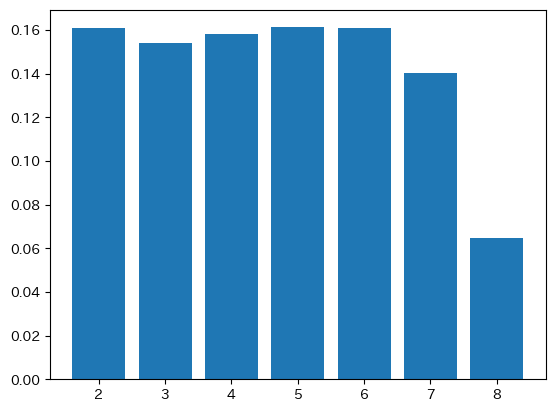

In [7]:
qwks = []
for p in np.arange(0.0, 1.01, 0.05):
    data_values = np.load(output_path + 'estimated_data_value.npy')
    if 逆張り:
        weights = remove_top_p_sample(data_values, top_p=p, ascending=False)
    else:
        weights = remove_top_p_sample(data_values, top_p=p, ascending=True)
    use_train_sample = (weights == 1)
    
    # Load data
    data = load_data(data_path)
    
    x_train = np.array(data['train']['feature'])
    x_dev = np.array(data['dev']['feature'])
    x_test = np.array(data['test']['feature'])
    
    y_train = np.array(data['train']['label'])
    y_dev = np.array(data['dev']['label'])
    y_test = np.array(data['test']['label'])
    
    train_essay_prompt = np.array(data['train']['essay_set'])
    dev_essay_prompt = np.array(data['dev']['essay_set'])
    test_essay_prompt = np.array(data['test']['essay_set'])
    
    train_essay_id = np.array(data['train']['essay_id'])
    dev_essay_id = np.array(data['dev']['essay_id'])
    test_essay_id = np.array(data['test']['essay_id'])
    
    # Normalize scores
    y_train = normalize_scores(y_train, train_essay_prompt, attribute_name)
    y_dev = normalize_scores(y_dev, dev_essay_prompt, attribute_name)
    y_test = normalize_scores(y_test, test_essay_prompt, attribute_name)
    
    sample_id = np.load(output_path + 'dev_ids.npy')
    not_sample_id = np.array([i for i in range(len(y_test)) if i not in sample_id])
    
    train_data = {}
    dev_data = {}
    test_data = {}
    
    train_data['feature'] = np.concatenate([x_train[use_train_sample], x_test[sample_id]], axis=0)
    train_data['normalized_label'] = np.concatenate([y_train[use_train_sample], y_test[sample_id]], axis=0)
    train_data['essay_set'] = np.concatenate([train_essay_prompt[use_train_sample], test_essay_prompt[sample_id]], axis=0)
    print(train_data['essay_set'])
    
    dev_data['feature'] = x_dev
    dev_data['normalized_label'] = y_dev
    dev_data['essay_set'] = dev_essay_prompt
    
    test_data['feature'] = x_test[not_sample_id]
    test_data['normalized_label'] = y_test[not_sample_id]
    test_data['essay_set'] = test_essay_prompt[not_sample_id]
    
    print(f'train size: {train_data["feature"].shape}')
    print(f'dev size: {dev_data["feature"].shape}')
    print(f'test size: {test_data["feature"].shape}')
    
    if 逆張り:
        top10per_list = train_essay_prompt[data_values.flatten().argsort()][:int(len(data_values)*(1-p))]
    else:
        top10per_list = train_essay_prompt[data_values.flatten().argsort()[::-1]][:int(len(data_values)*(1-p))]
    count = collections.Counter(top10per_list)
    plt.bar(list(count.keys()), [i / len(top10per_list) for i in list(count.values())])
    plt.savefig(output_path + 'high_value_prompt.png')
    
    for key, value in dict(count).items():
        count[key] = value / len(top10per_list)
    count
    
    prompt_list = [i for i in range(1, 9)]
    for prompt in prompt_list:
        if prompt not in count.keys():
            count[prompt] = 0
    count
    
    avg_weight_dict = dict((x, y) for x, y in sorted(count.items()))
    avg_weight_dict
    
    save_path = output_path + 'prompt_values/'
    os.makedirs(save_path, exist_ok=True)
    with open(save_path + f'prompt_value{p}.csv', 'wb') as f:
        pickle.dump(avg_weight_dict, f)
    
    avg_weight_list = [v for k, v in avg_weight_dict.items() if k != test_prompt_id]
    avg_weight_list
    
    import torch
    import torch.nn as nn
    from torch.optim import AdamW
    from transformers import get_linear_schedule_with_warmup
    from utils.evaluation import train_epoch, evaluate_epoch
    
    
    model_name = 'bert-base-uncased'
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name).to(device)
    config = AutoConfig.from_pretrained(model_name)
    
    # weights = np.concatenate([weights, np.ones_like(sample_id)], axis=0)
    # train_loader = create_data_loader(train_data, tokenizer, max_length=512, batch_size=32, weights=weights)
    train_loader = create_data_loader(train_data, tokenizer, max_length=512, batch_size=32)
    dev_loader = create_data_loader(dev_data, tokenizer, max_length=512, batch_size=32)
    test_loader = create_data_loader(test_data, tokenizer, max_length=512, batch_size=32)
    
    # set parameters
    EPOCHS = 10
    
    # Define the device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # device = torch.device('mps')
    print(f"Using {device}")
    
    # Define the model
    class PreTrainedScorer(nn.Module):
        def __init__(self, base_model: AutoModel, hidden_size=768, num_labels=1):
            super(PreTrainedScorer, self).__init__()
            self.base_model = base_model
            self.regressor = nn.Linear(hidden_size, num_labels)
            self.sigmoid = nn.Sigmoid()
    
        def forward(self, input_ids, attention_mask):
            outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask)
            pooled_output = outputs.pooler_output
            logits = self.regressor(pooled_output)
            return self.sigmoid(logits)
    
    # Initialize the model
    model = PreTrainedScorer(model, hidden_size=config.hidden_size).to(device)
    
    # Define loss function, optimizer, and scheduler
    loss_fn = nn.MSELoss(reduction='none').to(device)
    optimizer = AdamW(model.parameters(), lr=2e-5)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_loader)*EPOCHS)
    
    # Training loop
    best_test_metrics = [-1, -1, -1, -1, -1]
    best_val_metrics = [-1, -1, -1, -1, -1]
    best_test = [-1, -1, -1, -1, -1]
    for epoch in range(EPOCHS):
        print('BERT訓練中')
        print(f"Epoch {epoch+1}/{EPOCHS}")
    
        # Training Set
        train_loss = train_epoch(model, train_loader, loss_fn, optimizer, device, scheduler, use_weight=False)
        print(f"Training loss: {train_loss}")
    
        # Development Set
        dev_history = evaluate_epoch(model, dev_loader, loss_fn, device, attribute_name, avg_weight_list)
        print(f"Dev loss: {dev_history['loss']:.4f}")
    
        # Test Set
        eval_history = evaluate_epoch(model, test_loader, loss_fn, device, attribute_name)
        print(f"Test loss: {eval_history['loss']:.4f}")
    
        print(f'[VAL]  -> QWK: {dev_history["qwk"]: .3f}, CORR: {dev_history["corr"]: .3f}, RMSE: {dev_history["rmse"]: .3f}')
        print(f'[TEST] -> QWK: {eval_history["qwk"]: .3f}, CORR: {eval_history["corr"]: .3f}, RMSE: {eval_history["rmse"]: .3f}')
    
        if dev_history["qwk"] > best_val_metrics[0]:
            for i, met in enumerate(['qwk', 'lwk', 'corr', 'rmse', 'mae']):
                best_val_metrics[i] = dev_history[met]
                best_test_metrics[i] = eval_history[met]
        if eval_history["qwk"] > best_test[0]:
            for i, met in enumerate(['qwk', 'lwk', 'corr', 'rmse', 'mae']):
                best_test[i] = eval_history[met]
    
        print(f'[BEST] -> QWK: {best_test_metrics[0]: .3f}, CORR: {best_test_metrics[2]: .3f}, RMSE: {best_test_metrics[3]: .3f}')
    
    pd.DataFrame(np.array(best_test_metrics).reshape(1, 5), columns=['qwk', 'lwk', 'corr', 'rmse', 'mae']).to_csv(output_path + f'BERT_best_metrics{test_prompt_id}.csv', index=False, header=True)
    pd.DataFrame(np.array(best_test).reshape(1, 5), columns=['qwk', 'lwk', 'corr', 'rmse', 'mae']).to_csv(output_path + f'BERT_sample_metrics{test_prompt_id}.csv', index=False, header=True)

    qwks.append(best_test_metrics[0])

output_qwk = np.array([np.arange(0.0, 1.01, 0.05).tolist(), qwks])
pd.DataFrame(output_qwk).to_csv(output_path + 'bert_qwk.csv', index=False, header=False)

## 選ばれたデータを用いて，別モデルを学習 (PAES)

In [ ]:
qwks = []
for p in np.arange(0.0, 1.01, 0.05):
    from utils.read_data import read_essays_single_score, read_pos_vocab
    from utils.general_utils import get_single_scaled_down_score, pad_hierarchical_text_sequences
    from torch.utils.data import TensorDataset, DataLoader
    from models.PAES import PAES, fastPAES
    from utils.evaluation import train_model, evaluate_model
    
    # Load configs
    configs = Configs()
    
    data_path = configs.DATA_PATH3
    print(f'load data from {data_path}...')
    train_path = data_path + str(test_prompt_id) + '/train.pk'
    dev_path = data_path + str(test_prompt_id) + '/dev.pk'
    test_path = data_path + str(test_prompt_id) + '/test.pk'
    features_path = configs.FEATURES_PATH
    readability_path = configs.READABILITY_PATH
    vocab_size = configs.VOCAB_SIZE
    epochs = configs.EPOCHS
    batch_size = configs.BATCH_SIZE
    
    read_configs = {
        'train_path': train_path,
        'dev_path': dev_path,
        'test_path': test_path,
        'features_path': features_path,
        'readability_path': readability_path,
        'vocab_size': vocab_size
    }
    
    # Read data
    pos_vocab = read_pos_vocab(read_configs)
    train_data, dev_data, test_data = read_essays_single_score(read_configs, pos_vocab, attribute_name)
    
    # Get max sentence length and max sentence number
    max_sentnum = max(train_data['max_sentnum'], dev_data['max_sentnum'], test_data['max_sentnum'])
    max_sentlen = max(train_data['max_sentlen'], dev_data['max_sentlen'], test_data['max_sentlen'])
    
    # Scale down the scores
    train_data['y_scaled'] = get_single_scaled_down_score(train_data['data_y'], train_data['prompt_ids'], attribute_name)
    dev_data['y_scaled'] = get_single_scaled_down_score(dev_data['data_y'], dev_data['prompt_ids'], attribute_name)
    test_data['y_scaled'] = get_single_scaled_down_score(test_data['data_y'], test_data['prompt_ids'], attribute_name)
    
    # Pad the sequences with shape [batch, max_sentence_num, max_sentence_length]
    X_train_pos = pad_hierarchical_text_sequences(train_data['pos_x'], max_sentnum, max_sentlen)
    X_dev_pos = pad_hierarchical_text_sequences(dev_data['pos_x'], max_sentnum, max_sentlen)
    X_test_pos = pad_hierarchical_text_sequences(test_data['pos_x'], max_sentnum, max_sentlen)
    
    X_train_pos = X_train_pos.reshape((X_train_pos.shape[0], X_train_pos.shape[1] * X_train_pos.shape[2]))
    X_dev_pos = X_dev_pos.reshape((X_dev_pos.shape[0], X_dev_pos.shape[1] * X_dev_pos.shape[2]))
    X_test_pos = X_test_pos.reshape((X_test_pos.shape[0], X_test_pos.shape[1] * X_test_pos.shape[2]))
    
    # convert to tensor
    X_train= torch.tensor(X_train_pos, dtype=torch.long)
    X_dev = torch.tensor(X_dev_pos, dtype=torch.long)
    X_test= torch.tensor(X_test_pos, dtype=torch.long)
    
    X_train_linguistic_features = torch.tensor(np.array(train_data['features_x']), dtype=torch.float)
    X_dev_linguistic_features = torch.tensor(np.array(dev_data['features_x']), dtype=torch.float)
    X_test_linguistic_features = torch.tensor(np.array(test_data['features_x']), dtype=torch.float)
    
    X_train_readability = torch.tensor(np.array(train_data['readability_x']), dtype=torch.float)
    X_dev_readability = torch.tensor(np.array(dev_data['readability_x']), dtype=torch.float)
    X_test_readability = torch.tensor(np.array(test_data['readability_x']), dtype=torch.float)
    
    Y_train = torch.tensor(np.array(train_data['y_scaled']), dtype=torch.float)
    Y_dev = torch.tensor(np.array(dev_data['y_scaled']), dtype=torch.float)
    Y_test = torch.tensor(np.array(test_data['y_scaled']), dtype=torch.float)
    
    train_essay_set = torch.tensor(np.array(train_data['prompt_ids']), dtype=torch.long)
    dev_essay_set = torch.tensor(np.array(dev_data['prompt_ids']), dtype=torch.long)
    test_essay_set = torch.tensor(np.array(test_data['prompt_ids']), dtype=torch.long)
    
    # Load weights
    data_values = np.load(output_path + 'estimated_data_value.npy')
    if 逆張り:
        weights = remove_top_p_sample(data_values, top_p=p, ascending=False)
    else:
        weights = remove_top_p_sample(data_values, top_p=p, ascending=True)
    weights = (torch.tensor(weights, dtype=torch.float) == 1)
    
    sample_id = np.load(output_path + 'dev_ids.npy')
    not_sample_id = np.array([i for i in range(len(y_test)) if i not in sample_id])
    
    X_train = torch.concat([X_train[weights], X_test[sample_id]])
    Y_train = torch.concat([Y_train[weights], Y_test[sample_id]])
    X_train_linguistic_features = torch.concat([X_train_linguistic_features[weights], X_test_linguistic_features[sample_id]])
    X_train_readability = torch.concat([X_train_readability[weights], X_test_readability[sample_id]])
    train_essay_set = torch.concat([train_essay_set[weights], test_essay_set[sample_id]])
    
    X_test = X_test[not_sample_id]
    Y_test = Y_test[not_sample_id]
    X_test_linguistic_features = X_test_linguistic_features[not_sample_id]
    X_test_readability = X_test_readability[not_sample_id]
    test_essay_set = test_essay_set[not_sample_id]
    
    print(f'train size: {X_train.size()}')
    print(f'dev size: {X_dev.size()}')
    print(f'test size: {X_test.size()}')
    
    # Create Datasets
    train_dataset = TensorDataset(X_train, Y_train, X_train_linguistic_features, X_train_readability, train_essay_set)
    dev_dataset = TensorDataset(X_dev, Y_dev, X_dev_linguistic_features, X_dev_readability, dev_essay_set)
    test_dataset = TensorDataset(X_test, Y_test, X_test_linguistic_features, X_test_readability, test_essay_set)
    # Create Dataloaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    dev_loader = DataLoader(dataset=dev_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    
    import torch.nn as nn
    import torch.optim as optim
    import torch
    
    model = fastPAES(max_sentnum, max_sentlen, X_train_linguistic_features.size(1), X_train_readability.size(1), pos_vocab=pos_vocab)
    model = model.to(device)
    print(model)
    
    # Create loss and optimizer
    reduction = 'mean'
    MSE_Loss = nn.MSELoss(reduction=reduction).to(device)
    optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
    
    train_history = []
    dev_history = []
    test_history = []
    best_test_metrics = [-1, -1, -1, -1, -1]
    best_val_metrics = [-1, -1, -1, -1, -1]
    best_test = [-1, -1, -1, -1, -1]
    for epoch in range(epochs):
        print('PAES訓練中')
        print('{} / {} EPOCHS'.format(epoch+1, epochs))
        print('Seed: {}, Prompt: {}'.format(seed, test_prompt_id))
        
        # Train the model
        train_loss = train_model(model, train_loader, MSE_Loss, optimizer, device, weight=False)
        print(f'Train loss: {train_loss: .4f}')
        train_history.append(train_loss)
    
        # Evaluate the model on dev set
        dev_results = evaluate_model(model, dev_loader, MSE_Loss, device, attribute_name, avg_weight_list)
        print(f'Validation loss: {dev_results["loss"]: .4f}')
        dev_history.append(dev_results["loss"])
    
        # Evaluate the model on test set
        test_results = evaluate_model(model, test_loader, MSE_Loss, device, attribute_name)
        print(f'Test loss: {test_results["loss"]: .4f}')
        test_history.append(test_results["loss"])
    
        if dev_results["qwk"] > best_val_metrics[0]:
            for i, met in enumerate(['qwk', 'lwk', 'corr', 'rmse', 'mae']):
                best_val_metrics[i] = dev_results[met]
                best_test_metrics[i] = test_results[met]
        if test_results["qwk"] > best_test[0]:
            for i, met in enumerate(['qwk', 'lwk', 'corr', 'rmse', 'mae']):
                best_test[i] = test_results[met]
    
        # if epoch % 10 == 0:
        #     print(f'[VAL]  -> QWK: {dev_results["qwk"]: .3f}, CORR: {dev_results["corr"]: .3f}, RMSE: {dev_results["rmse"]: .3f}')
        #     print(f'[TEST] -> QWK: {test_results["qwk"]: .3f}, CORR: {test_results["corr"]: .3f}, RMSE: {test_results["rmse"]: .3f}')
        #     print(f'[BEST] -> QWK: {best_test_metrics[0]: .3f}, CORR: {best_test_metrics[2]: .3f}, RMSE: {best_test_metrics[3]: .3f}')
        
    pd.DataFrame(np.array(best_test_metrics).reshape(1, 5), columns=['qwk', 'lwk', 'corr', 'rmse', 'mae']).to_csv(output_path + f'PAES_best_metrics{test_prompt_id}.csv', index=False, header=True)
    pd.DataFrame(np.array(best_test).reshape(1, 5), columns=['qwk', 'lwk', 'corr', 'rmse', 'mae']).to_csv(output_path + f'PAES_sample_metrics{test_prompt_id}.csv', index=False, header=True)

output_qwk = np.array([np.arange(0.0, 1.01, 0.05).tolist(), qwks])
pd.DataFrame(output_qwk).to_csv(output_path + 'PAES_qwk.csv', index=False, header=False)

条件付き確率で選ぶ
広げる損失を分散を大きくする